In [47]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [48]:
# Disable warning messages
import warnings
warnings.filterwarnings('ignore')

In [49]:
#uploading dataset
df = pd.read_csv(r'C:\Users\AYUSH\Downloads\KaggleDataset\online_shoppers_intention.csv')
df.shape

(12330, 18)

In [50]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [52]:
df.loc[:,['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = df[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype('int64').astype('object')

In [53]:
#Perform EDA process begins
sns.set_theme()

In [54]:
# Search for null values
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [55]:
# Search for duplicate values
df.duplicated().sum(), df.shape

(125, (12330, 18))

In [56]:
# Deleting duplicate rows
df.drop_duplicates(inplace=True, keep='first')
df.duplicated().sum(), df.shape

(0, (12205, 18))

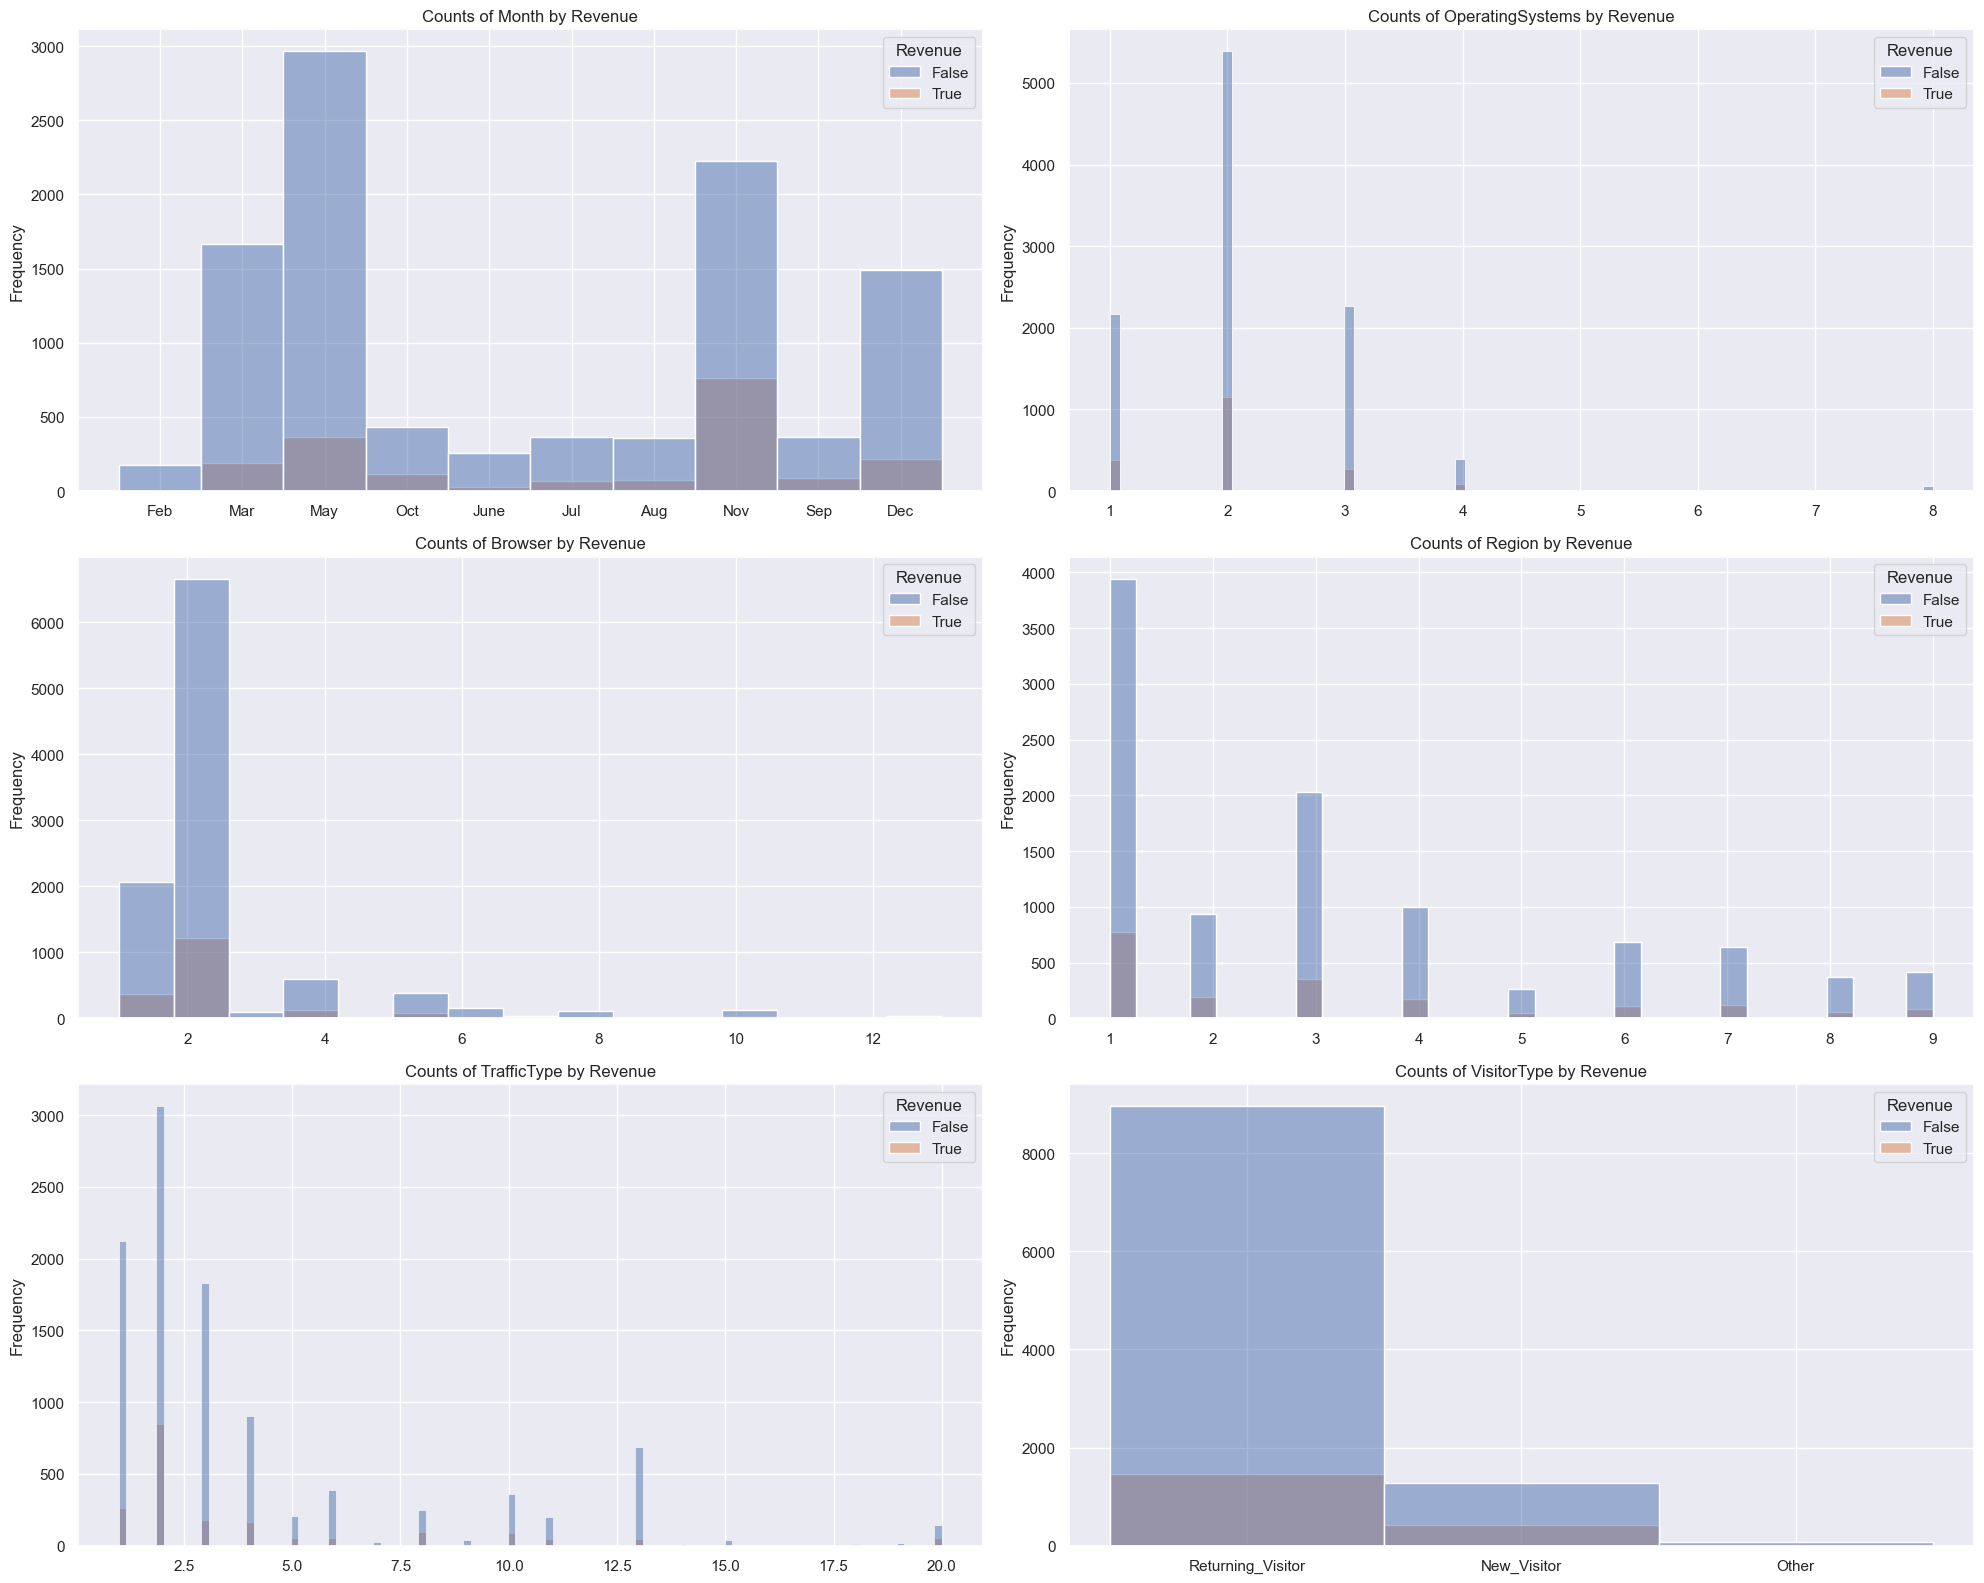

In [57]:
#EDA Process
#Distribution of Categorical variables
# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(20, 16))

# Plot histograms for numerical features based on the value of the target variable 'Revenue'
for col, ax in zip(df.select_dtypes(include='object').columns, axes.flatten()):
    sns.histplot(data=df, x=df[col].values, hue="Revenue", ax=ax)
    ax.set_title(f'Counts of {col} by Revenue')
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

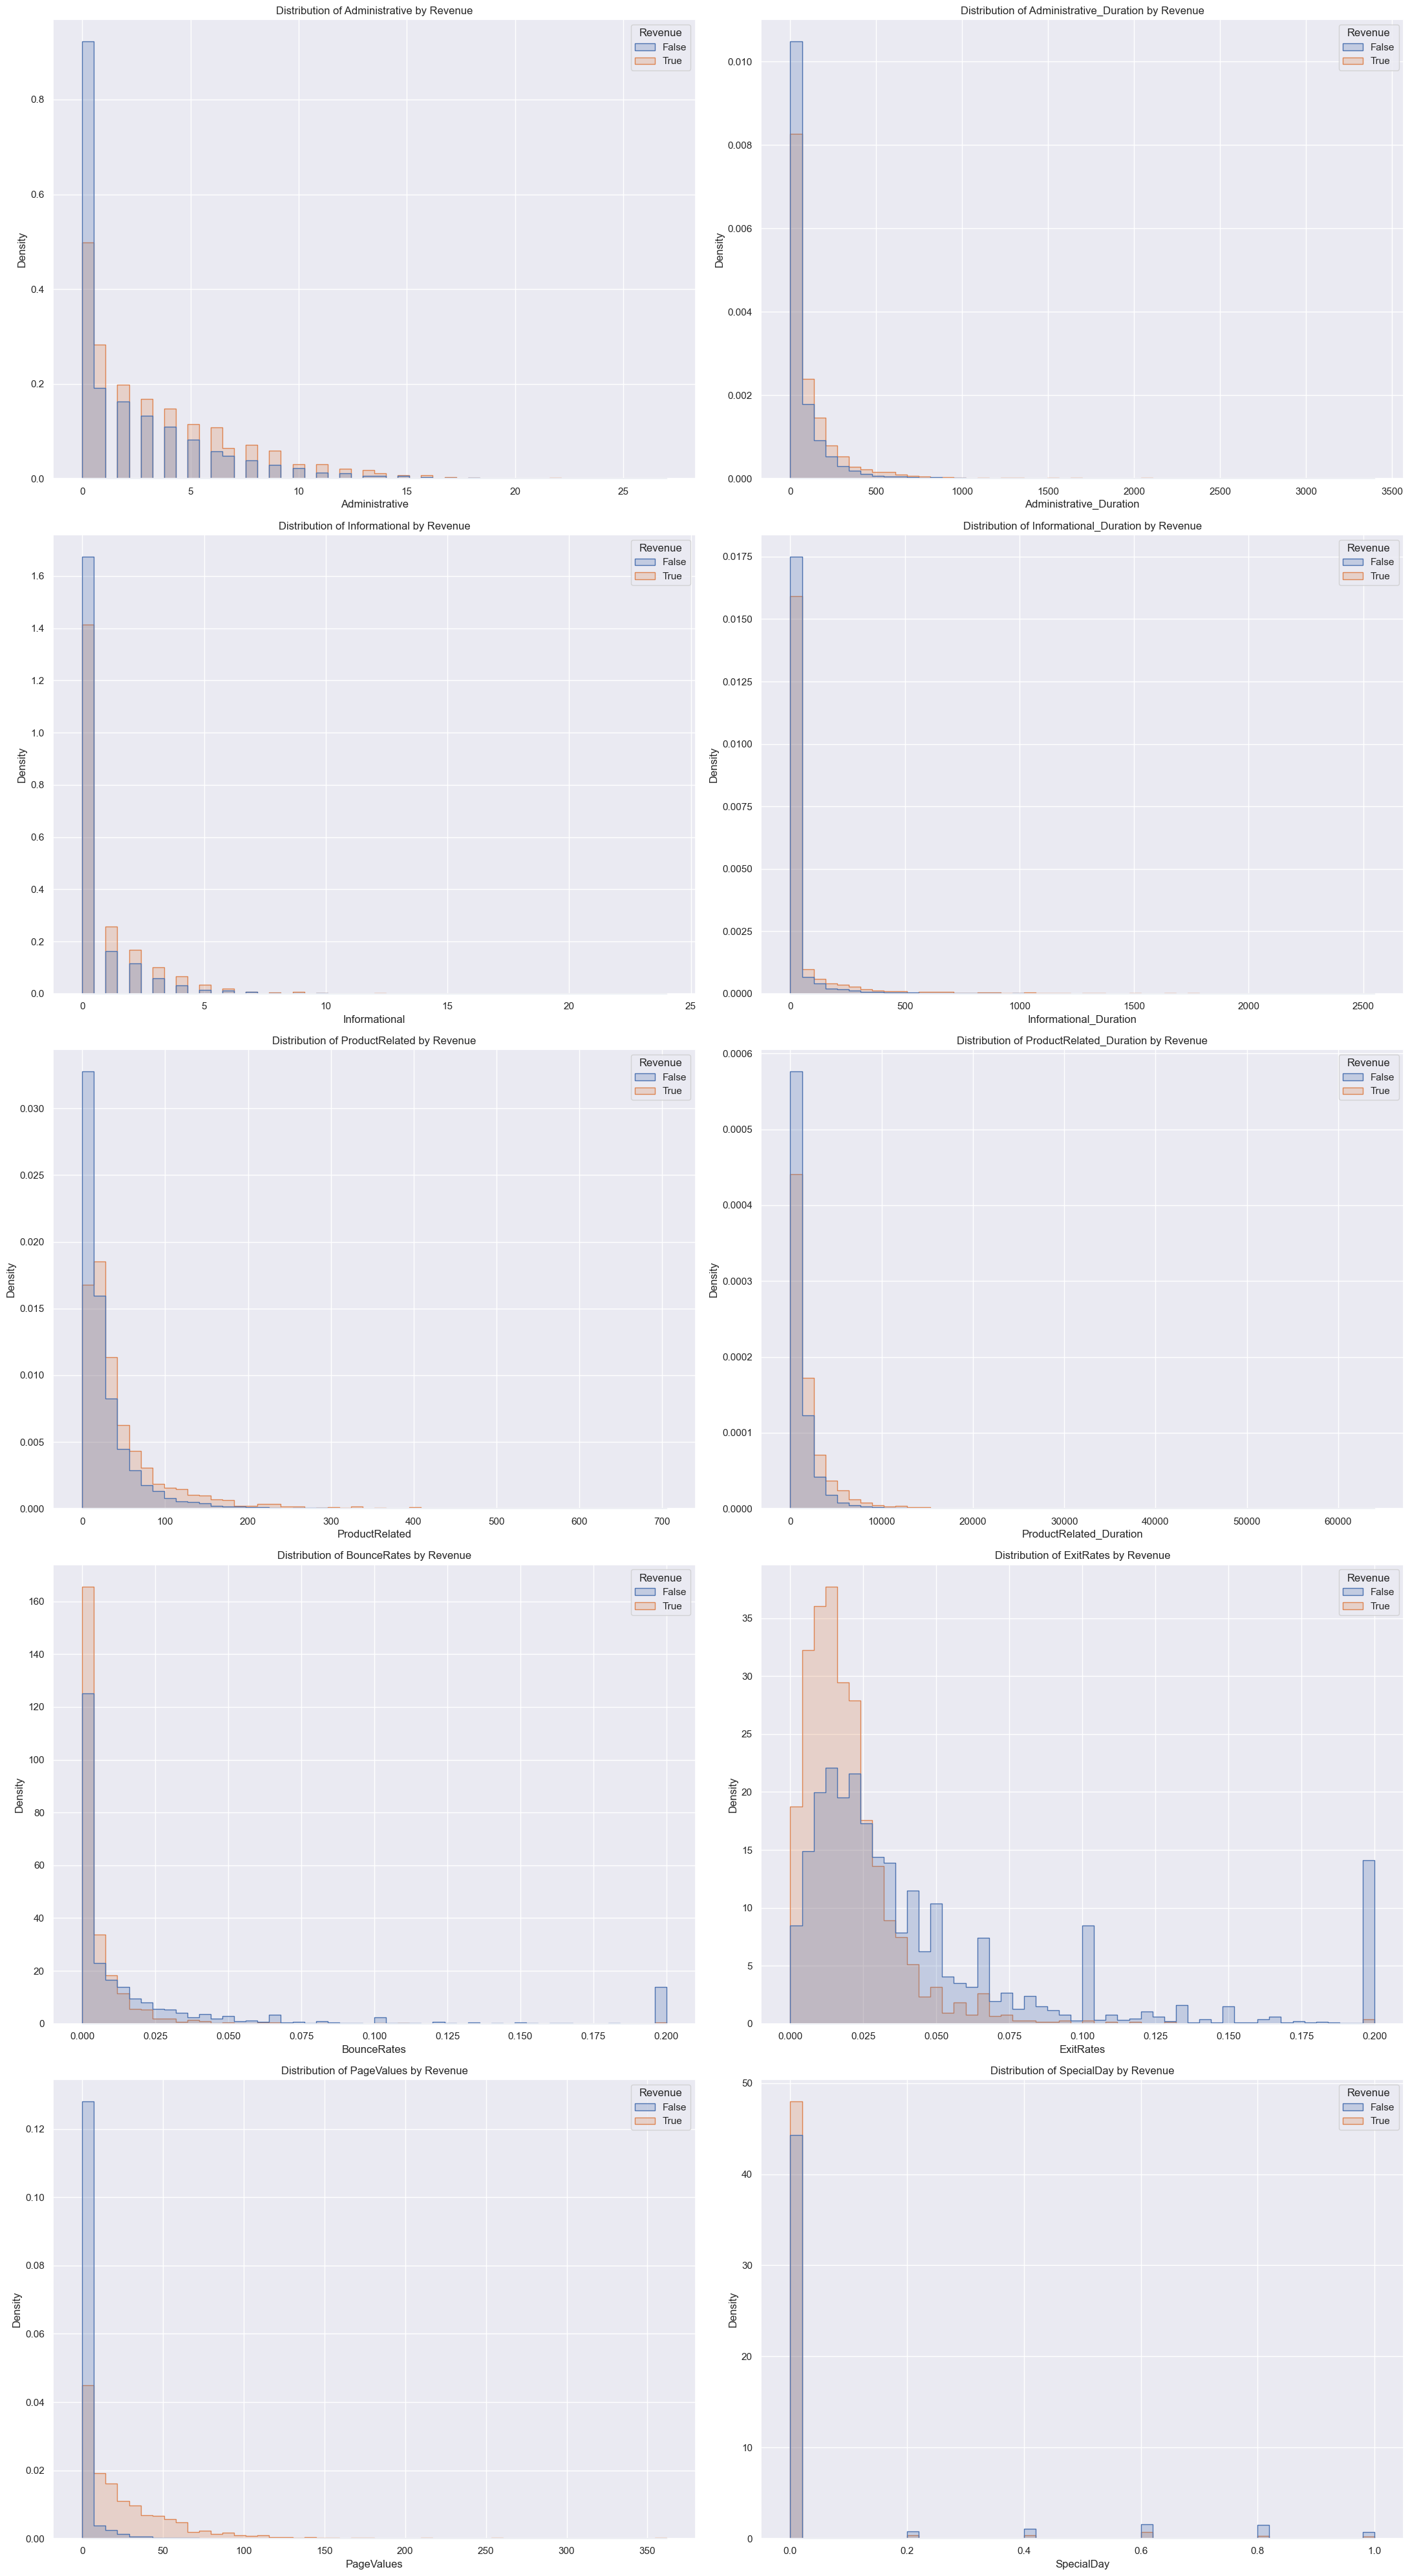

In [58]:
#Distributions of numerical features
#We plot the distribution of numerical features
sns.set_theme()
# Set up the matplotlib figure
fig, axes = plt.subplots(5, 2, figsize=(22, 40))

# Plot histograms for numerical features based on the value of the target variable 'Revenue'
for col, ax in zip(df.select_dtypes(include='number').columns, axes.flatten()):
    sns.histplot(data=df, x=col, hue="Revenue", element="step", stat="density", common_norm=False, bins=50, ax=ax)
    ax.set_title(f'Distribution of {col} by Revenue')

plt.tight_layout()
plt.show()

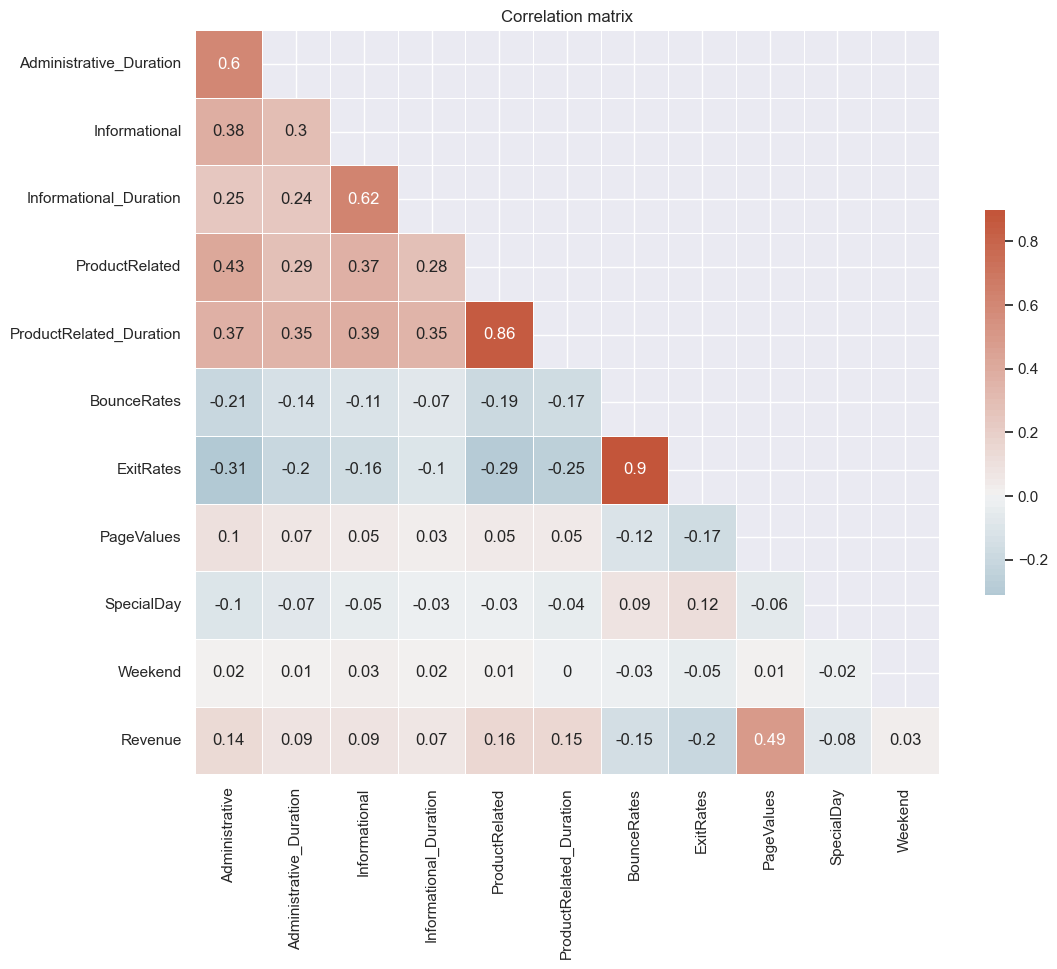

In [59]:
#Correlation matrix for the target variable "Revenue"
# Moving the Revenue label to the end for better visualisation
cols = [c for c in df if c != 'Revenue'] + ['Revenue']
df = df[cols]

# Correlational Matrix
df_corr_matrix = df[df.select_dtypes(include=['number', 'bool']).columns].corr().round(2)

# Plotting
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(df_corr_matrix))
cmap = sns.diverging_palette(230, 20, n=100)
ax = sns.heatmap(df_corr_matrix, mask=mask, annot=True, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xlim(0,len(df_corr_matrix)-1)
ax.set_ylim(len(df_corr_matrix),1)
#ax.collections[0].set_clim(-1,1) 
plt.title('Correlation matrix')
plt.show()

In [60]:
#Separate features and target
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)  # Convert True/False to 1/0


In [61]:
#Data Preprocessing part
#4. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [62]:
#5. Define preprocessing transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])


In [63]:
#6. Fit-transform preprocessing to verify
X_preprocessed = preprocessor.fit_transform(X)
print(X_preprocessed.shape)


(12205, 68)


In [64]:
#Logistic Regression Model Implementation
# 1. Select features and target
selected_features = ['PageValues', 'ProductRelated', 'ExitRates', 'BounceRates' ,'Administrative_Duration','ProductRelated_Duration']
X = df[selected_features]
y = df['Revenue'].astype(int)

# 2. Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Fit Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# 5. Predict and evaluate
y_pred = model.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      2059
           1       0.79      0.38      0.52       382

    accuracy                           0.89      2441
   macro avg       0.84      0.68      0.73      2441
weighted avg       0.88      0.89      0.87      2441

Confusion Matrix:
 [[2020   39]
 [ 235  147]]
Accuracy: 0.8878


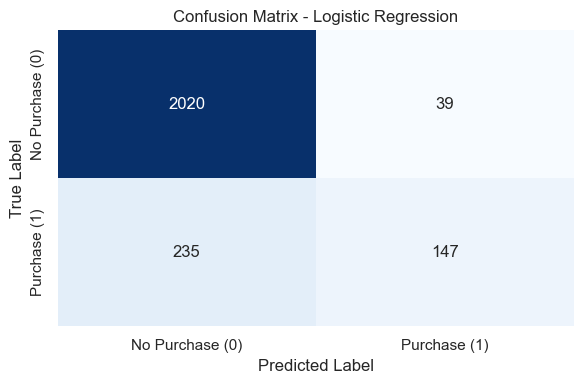

In [65]:
# Visualizing Logistic Regression Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Purchase (0)', 'Purchase (1)'],
            yticklabels=['No Purchase (0)', 'Purchase (1)'])

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


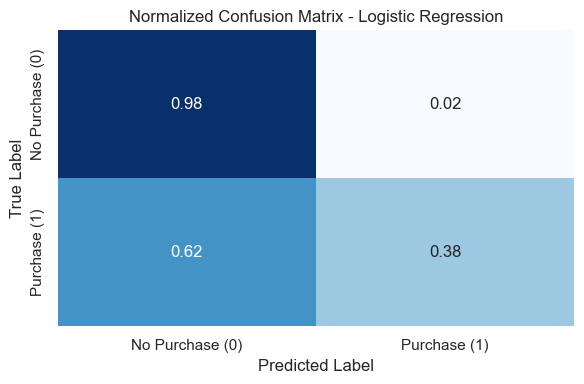

In [66]:
#Visualizing Logistic Regression of Normalized Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix and Normalization
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['No Purchase (0)', 'Purchase (1)'],
            yticklabels=['No Purchase (0)', 'Purchase (1)'])

plt.title("Normalized Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


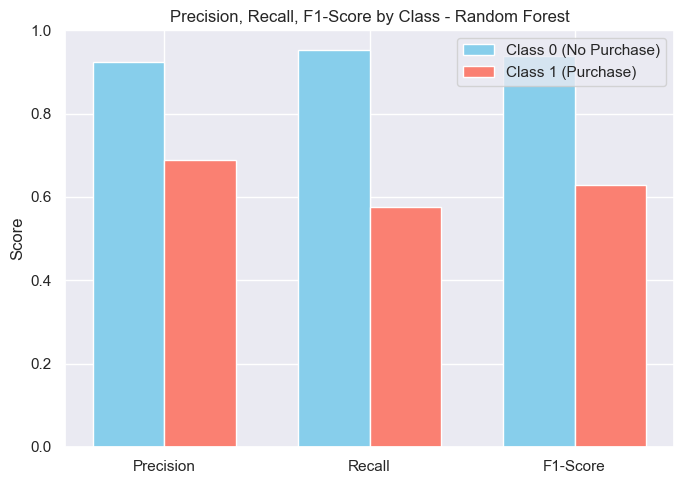

In [80]:
# Visualization of  Precision, Recall, F1-Score Bar Plot (Per Class) of Logistic Regression

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Metrics
precision_0 = precision_score(y_test, y_pred_rf, pos_label=0)
recall_0 = recall_score(y_test, y_pred_rf, pos_label=0)
f1_0 = f1_score(y_test, y_pred_rf, pos_label=0)

precision_1 = precision_score(y_test, y_pred_rf, pos_label=1)
recall_1 = recall_score(y_test, y_pred_rf, pos_label=1)
f1_1 = f1_score(y_test, y_pred_rf, pos_label=1)

# Plot
labels = ['Precision', 'Recall', 'F1-Score']
class0 = [precision_0, recall_0, f1_0]
class1 = [precision_1, recall_1, f1_1]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, class0, width, label='Class 0 (No Purchase)', color='skyblue')
plt.bar(x + width/2, class1, width, label='Class 1 (Purchase)', color='salmon')

plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score by Class - Random Forest")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


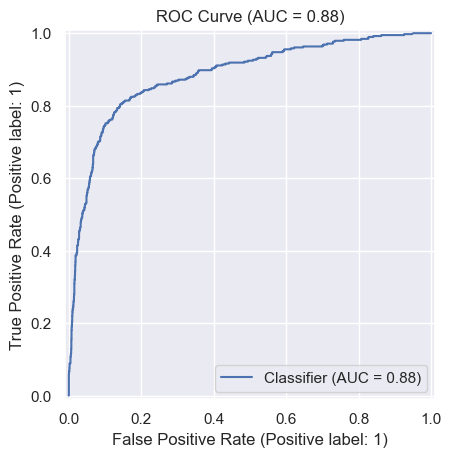

In [68]:
# ROC Curve of Logistic Regression
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_proba = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()


In [69]:
#decision tree Model Implementation
# 1. Use same selected features and target
selected_features = ['PageValues', 'ProductRelated', 'ExitRates', 'BounceRates']
X = df[selected_features]
y = df['Revenue'].astype(int)

# 2. Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Fit Decision Tree (no need to scale for trees)
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred_dt = dt_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2059
           1       0.56      0.56      0.56       382

    accuracy                           0.86      2441
   macro avg       0.74      0.74      0.74      2441
weighted avg       0.86      0.86      0.86      2441

Confusion Matrix:
 [[1892  167]
 [ 168  214]]
Accuracy: 0.8628


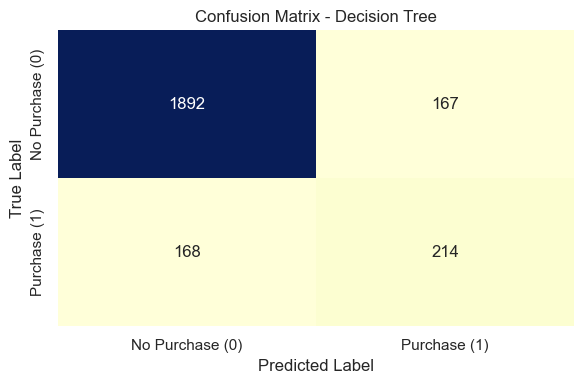

In [70]:
# Visualization of Decision Tree - Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['No Purchase (0)', 'Purchase (1)'],
            yticklabels=['No Purchase (0)', 'Purchase (1)'])

plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


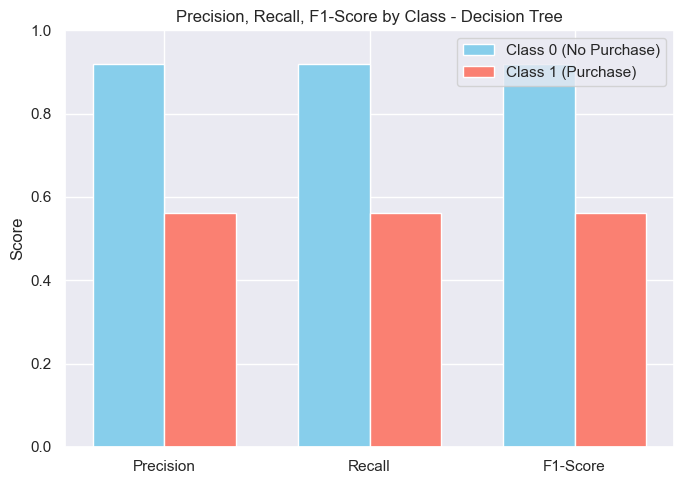

In [71]:
# Decision Tree --- Precision , Recall , F1-Score Visualization
# Calculate metrics per class
precision_0 = precision_score(y_test, y_pred_dt, pos_label=0)
recall_0 = recall_score(y_test, y_pred_dt, pos_label=0)
f1_0 = f1_score(y_test, y_pred_dt, pos_label=0)

precision_1 = precision_score(y_test, y_pred_dt, pos_label=1)
recall_1 = recall_score(y_test, y_pred_dt, pos_label=1)
f1_1 = f1_score(y_test, y_pred_dt, pos_label=1)

# Bar chart setup
import numpy as np

labels = ['Precision', 'Recall', 'F1-Score']
class0 = [precision_0, recall_0, f1_0]
class1 = [precision_1, recall_1, f1_1]

x = np.arange(len(labels))
width = 0.35

# Plot
plt.figure(figsize=(7, 5))
plt.bar(x - width/2, class0, width, label='Class 0 (No Purchase)', color='skyblue')
plt.bar(x + width/2, class1, width, label='Class 1 (Purchase)', color='salmon')

plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score by Class - Decision Tree")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


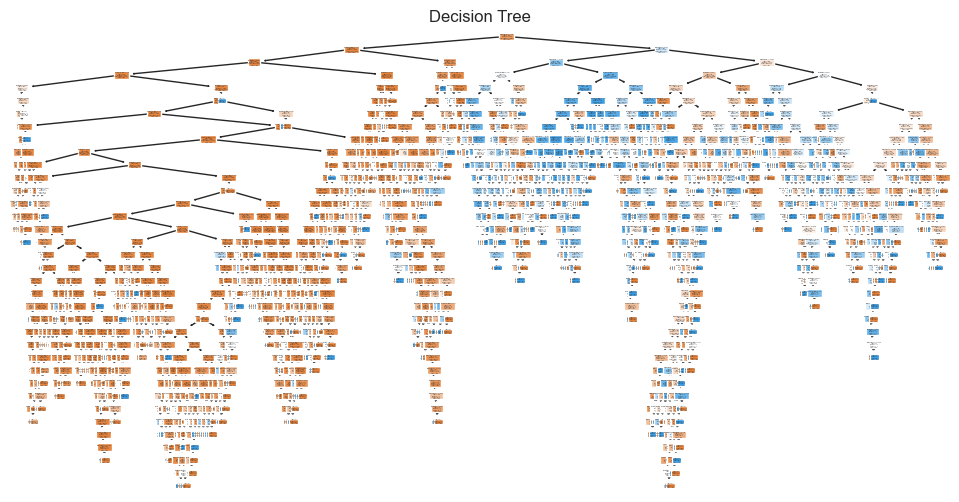

In [72]:
# visual representation of a Decision Tree model
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 6))
plot_tree(dt_model, feature_names=selected_features, class_names=['No', 'Yes'], filled=True)
plt.title("Decision Tree")
plt.show()


In [74]:
# Random Forest Model Implementation
# 1. Features and target
selected_features = ['PageValues', 'ProductRelated', 'ExitRates', 'BounceRates']
X = df[selected_features]
y = df['Revenue'].astype(int)

# 2. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Fit Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Predictions
y_pred_rf = rf_model.predict(X_test)

# 5. Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# 6. Training accuracy
train_acc_rf = rf_model.score(X_train, y_train)
print(f"Training Accuracy: {train_acc_rf:.4f}")


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      2059
           1       0.69      0.58      0.63       382

    accuracy                           0.89      2441
   macro avg       0.81      0.76      0.78      2441
weighted avg       0.89      0.89      0.89      2441

Confusion Matrix:
 [[1960   99]
 [ 162  220]]
Test Accuracy: 0.8931
Training Accuracy: 0.9930


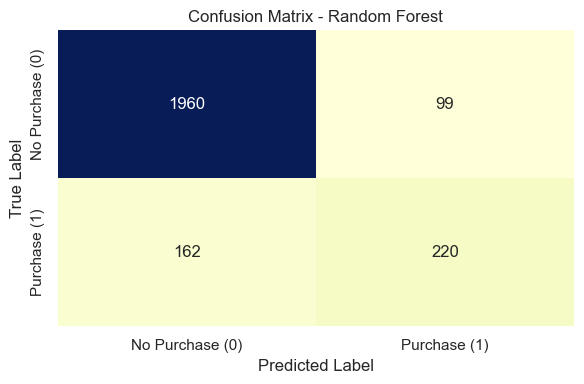

In [75]:
# Random Forest - Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['No Purchase (0)', 'Purchase (1)'],
            yticklabels=['No Purchase (0)', 'Purchase (1)'])

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


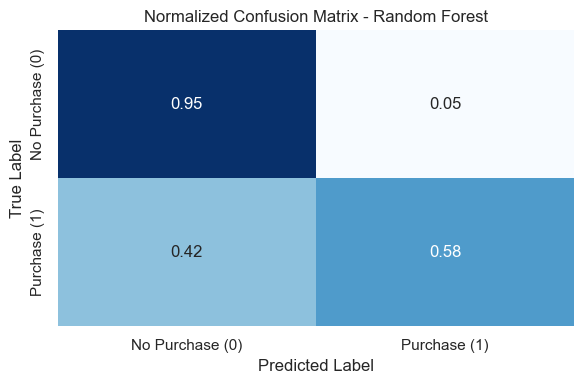

In [76]:
# Normalize COnfusion Matrix Of Random Forest
cm_rf_norm = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['No Purchase (0)', 'Purchase (1)'],
            yticklabels=['No Purchase (0)', 'Purchase (1)'])

plt.title("Normalized Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


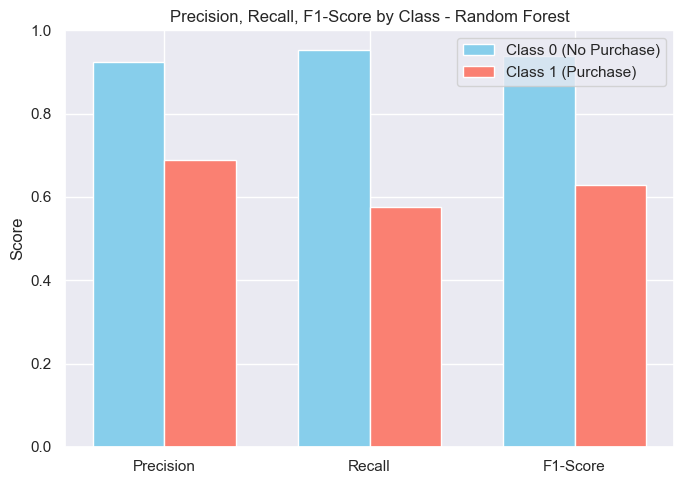

In [77]:
#Visualization Of Precision , Recall , F1-Score of Random Forest
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Metrics
precision_0 = precision_score(y_test, y_pred_rf, pos_label=0)
recall_0 = recall_score(y_test, y_pred_rf, pos_label=0)
f1_0 = f1_score(y_test, y_pred_rf, pos_label=0)

precision_1 = precision_score(y_test, y_pred_rf, pos_label=1)
recall_1 = recall_score(y_test, y_pred_rf, pos_label=1)
f1_1 = f1_score(y_test, y_pred_rf, pos_label=1)

# Plot
labels = ['Precision', 'Recall', 'F1-Score']
class0 = [precision_0, recall_0, f1_0]
class1 = [precision_1, recall_1, f1_1]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, class0, width, label='Class 0 (No Purchase)', color='skyblue')
plt.bar(x + width/2, class1, width, label='Class 1 (Purchase)', color='salmon')

plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score by Class - Random Forest")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


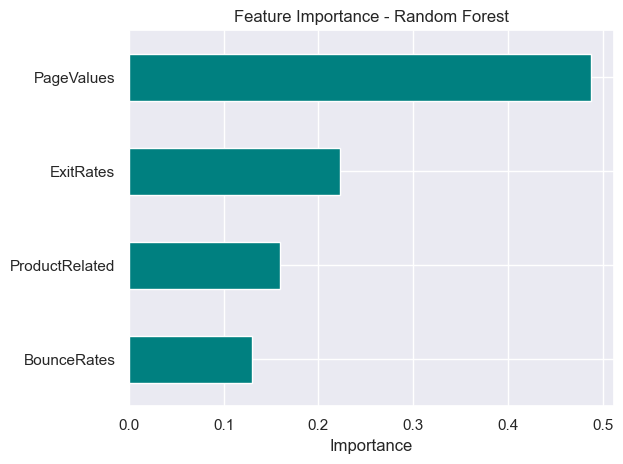

In [78]:
# Feature importances of Random Forest
import pandas as pd

importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=selected_features)

# Plot
feat_importance.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
